In [1]:
import numpy as np
import matplotlib.pyplot as plt

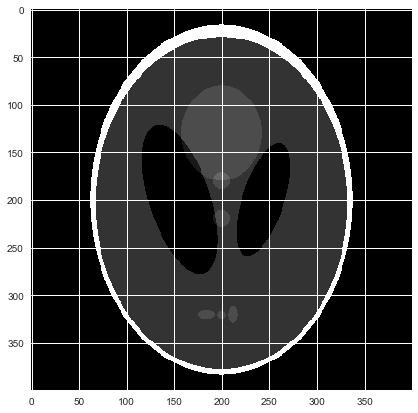

In [4]:
from skimage import data_dir
from skimage.io import imread
import pywt

I = imread(data_dir + "/phantom.png", as_gray=True)

plt.figure(figsize=(7, 7))
plt.imshow(I, cmap='gray')
plt.show()

In [3]:
def imshowgray(im, vmin=None, vmax=None):
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=vmin, vmax=vmax)

    
def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res


def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

    
def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))


def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

    
def img2coeffs(Wim, levels=4):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
    
def dwt2(im):
    coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=4)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim


def idwt2(Wim):
    coeffs = img2coeffs(Wim, levels=4)
    return pywt.waverec2(coeffs, wavelet='db4', mode='per')

Reconstruction error: 7.26607737699601e-14


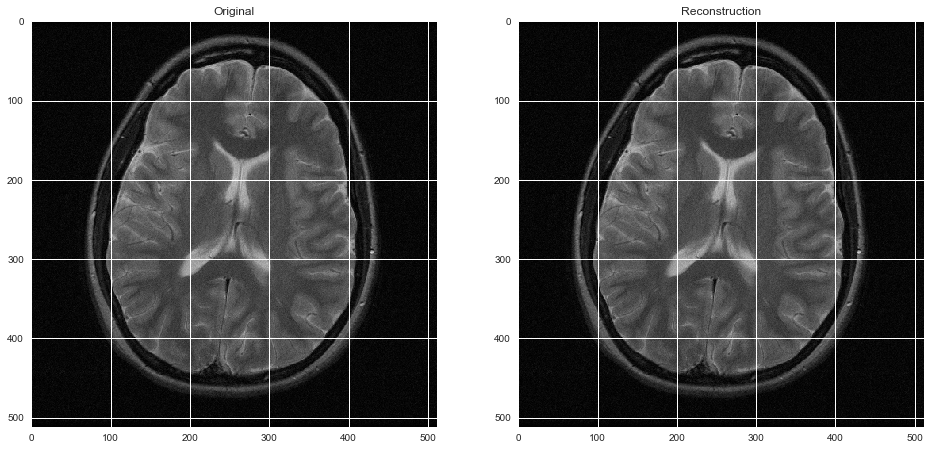

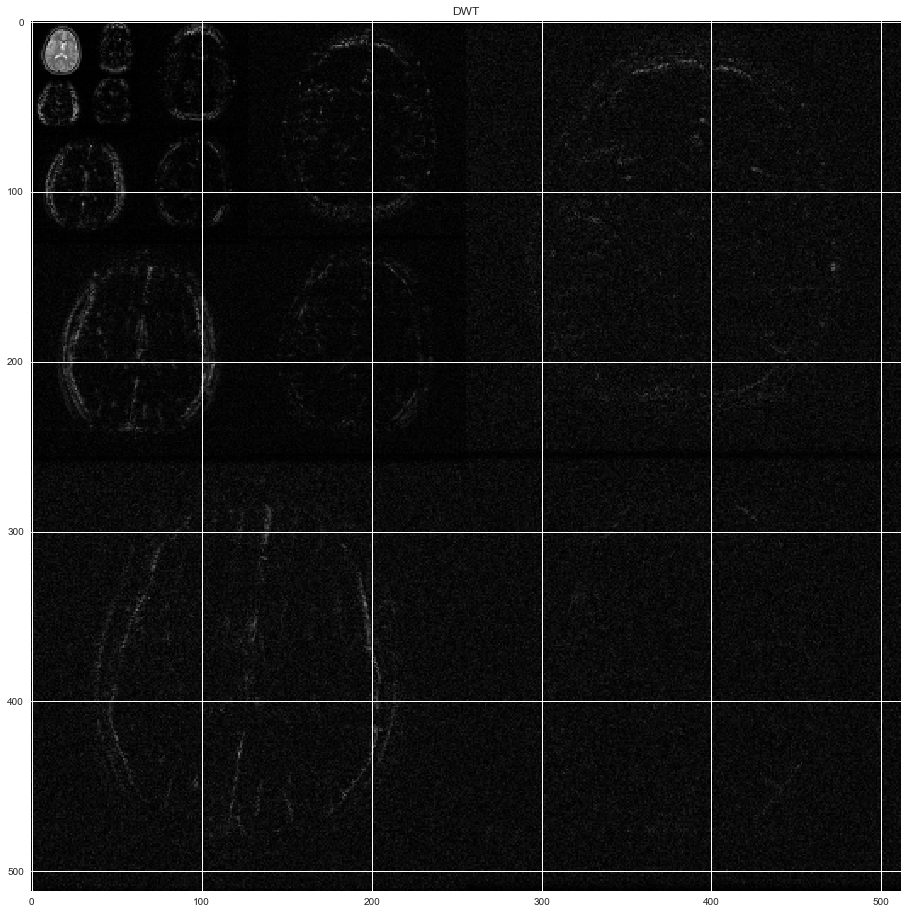

In [5]:
data = np.load("./data/brain.npz")
im, mask_unif, mask_vardens, pdf_unif, pdf_vardens = \
data['im'], data['mask_unif'], data['mask_vardens'], data['pdf_unif'], data['pdf_vardens']

Wim = dwt2(im)
im2 = idwt2(Wim)


plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
imshowgray(np.abs(im))
plt.title('Original')

plt.subplot(1,2,2)
imshowgray(np.abs(im2))
plt.title('Reconstruction')

plt.figure(figsize=(16, 16))
imshowWAV(Wim)
plt.title('DWT')


print('Reconstruction error:', np.linalg.norm(im - im2))

Reconstruction error: 15.303326958445902


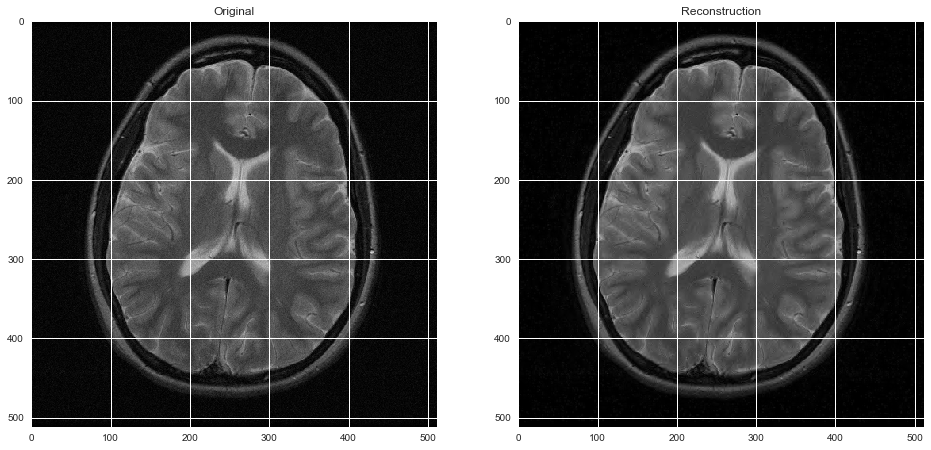

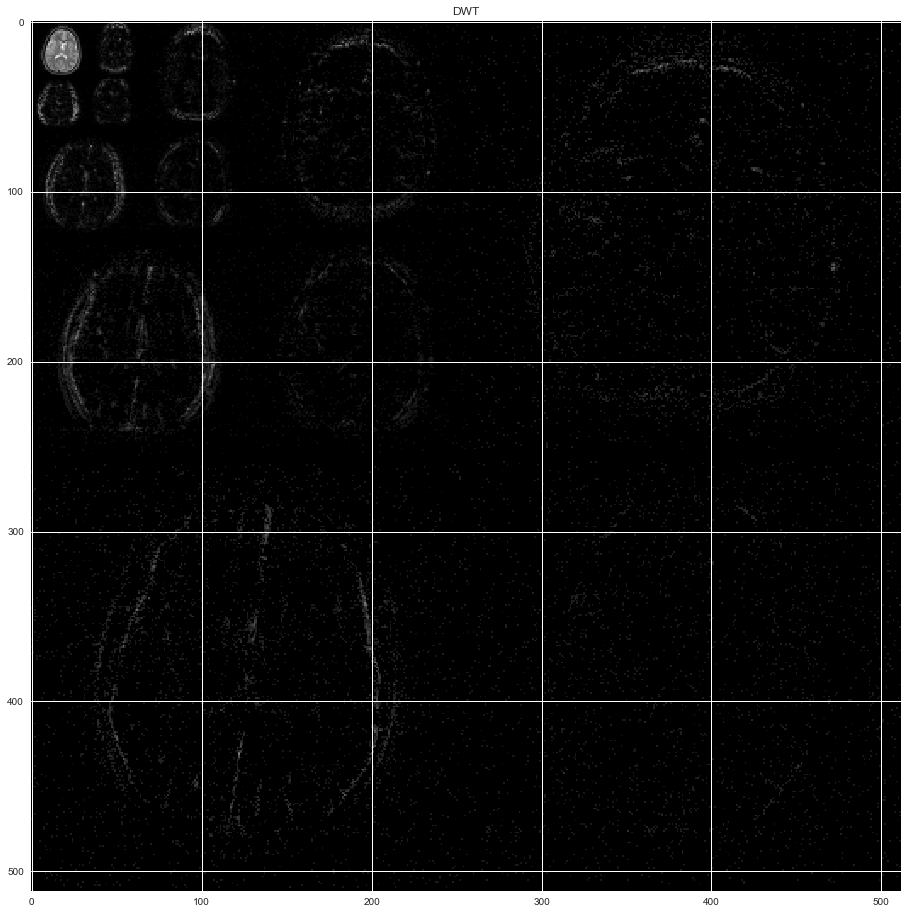

In [6]:
# Wavelet threshold
f = 0.1
m = np.sort(abs(Wim.ravel()))[::-1]
ndx = int(len(m) * f)
thr = m[ndx]
Wim_thr = Wim * (abs(Wim) > thr)

im2 = idwt2(Wim_thr)

plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
imshowgray(np.abs(im))
plt.title('Original')

plt.subplot(1,2,2)
imshowgray(np.abs(im2))
plt.title('Reconstruction')

plt.figure(figsize=(16, 16))
imshowWAV(Wim_thr)
plt.title('DWT')


print('Reconstruction error:', np.linalg.norm(im - im2))